In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

In [67]:
def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

def check_class(it):
    if '협박' in it:
        return 0
    elif '갈취' in it:
        return 1
    elif '직장 내 괴롭힘' in it:
        return 2
    elif '기타 괴롭힘' in it:
        return 3
    else:
        return 4



In [68]:
train_data_path = "/home/ubuntu/dev/study/nlp/papago/train.csv"
train_data = pd.read_csv(train_data_path)

train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [70]:
train_data = train_data.sample(frac = 1, random_state = 42)

In [71]:
#train_data['data'] = train_data['conversation'].apply(lambda it : preprocess_sentence(it))
train_data['data'] = train_data['conversation']
train_data['label'] = train_data['class'].apply(lambda it: check_class(it))

train_data = train_data[['data', 'label']]

train_data.head()

,data,label
1852,저기 학생 잠시만\n네\n미안한데 내가 지갑을 잃어버려서 그런데 집에갈 차비가없어서...,1
2554,김비씨 이번 연휴에 뭐했어 ?\n 서울 근교로 잠깐 나들이 다녀왔습니다!\n 그래?...,2
3896,후라이팬 환불좀 해주세요\n네? 고객님 구매는 언제 하셨을까여\n구매가 언제한지가 ...,3
2828,저기요 사장님\n네 무슨일인가요?\n제가 여기서 짜장면을 사갔는데.상태가 안좋네요....,3
966,오늘은 내가 쏠게 비싼 거 먹어\n 그래 잘 먹을게\n 잘 먹었다. 아차 어쩌지 나...,1


In [72]:
# 클래스별 갯수 확인
train_data.groupby("label").count()

,data
label,
0,896
1,981
2,979
3,1094


In [73]:
# 1100개 기준 부족 데이터 확인
train_data.groupby("label").count()*(1-(train_data.groupby("label").count()/1100))

,data
label,
0,166.167273
1,106.126364
2,107.690000
3,5.967273


- 0번 데이터는 AIHUB에서 가져왔기 때문에 제외
- 3번 데이터는 이미 충분히 많기 때문에 제외
- 1번, 2번 데이터를 타겟으로

- 전체적으로 많이 늘리고싶지만 리미트가 있어서, 최대한 효율적으로

In [74]:
# 빈값 확인
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3950 entries, 1852 to 3393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    3950 non-null   object
 1   label   3950 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 92.6+ KB


In [75]:
# 텍스트 데이터 길이 확인
min_length = train_data['data'].str.len().min()
max_length = train_data['data'].str.len().max()
avg_length = train_data['data'].str.len().mean()
summary_data = {
    'Statistic': ['Minimum Length', 'Maximum Length', 'Average Length'],
    'Value': [min_length, max_length, avg_length]
}
summary_df = pd.DataFrame(summary_data)
print(summary_df)

        Statistic       Value
0  Minimum Length   41.000000
1  Maximum Length  874.000000
2  Average Length  226.570886


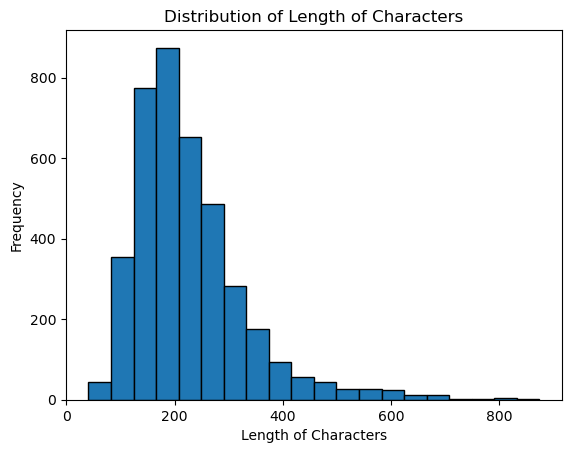

In [76]:
# 텍스트 길이 분포 확인
lengths = train_data['data'].str.len()

# Create a histogram to visualize the distribution
plt.hist(lengths, bins=20, edgecolor='black')
plt.xlabel('Length of Characters')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Characters')
plt.show()

In [77]:
# 길이가 0 ~ 100인 값 갯수 확인
train_data['length'] = train_data['data'].str.len()
filtered_data = train_data[(train_data['length'] >= 0) & (train_data['length'] <= 100)]
filtered_data.groupby(['label']).count()

,data,length
label,,
0,14,14
1,49,49
2,24,24
3,50,50


In [78]:
# 길이가 100 ~ 150인 값 갯수 확인
train_data['length'] = train_data['data'].str.len()
filtered_data = train_data[(train_data['length'] >= 100) & (train_data['length'] <= 150)]
filtered_data.groupby(['label']).count()

,data,length
label,,
0,106,106
1,222,222
2,137,137
3,276,276


In [79]:
filtered_data.sample(200).groupby("label").count()

,data,length
label,,
0,27,27
1,58,58
2,36,36
3,79,79


In [80]:
# 라벨 값 : 1, 2  조건 검색 후 반띵
#label1_data = filtered_data[(filtered_data['label']==1) | (filtered_data['label'] ==2)].sample(100, random_state = 2)
label1_data = filtered_data[(filtered_data['label']==1)].sample(50, random_state = 2)
label2_data = filtered_data[(filtered_data['label']==2)].sample(50, random_state = 2)

filtered_data = pd.concat([label1_data, label2_data], ignore_index=True)
filtered_data.groupby('label').count()


,data,length
label,,
1,50,50
2,50,50


In [81]:
# length 열 제거
filtered_data1 = filtered_data.drop(['length'], axis=1)
filtered_data1

,data,label
0,가진 거 다 내놔\n뭐래는거야 이 사람이\n지금 내말 안들으면 후회할텐데\n왜 그러...,1
1,철민아 오늘은 얼마 가지고 왔냐?\n오늘은 만원 밖에 없어요.\n진짜냐?\n정말이에...,1
2,얼마 가져왔어?\n십만원 정도.\n야 이걸로 새 폰을 어떻게 사\n이게 최선이었어....,1
3,핸드폰 좋아보이네 \n저요?\n핸드폰 보고 있는 사람 너잖아\n제 핸드폰인데 왜 그...,1
4,우와 이거 예쁘다! 나 주라.\n 싫어 내 거야.\n 싫어 예뻐서 내가 갖고 싶어....,1
...,...,...
95,아니 안대리 일을 왜 그 따위로 밖에 못해\n안대로 또 사고쳤나? 일처리 똑바로 안...,2
96,이대리. 똑바로 안 할거야?\n죄송합니다.\n회사가 이러려고 너 뽑은 줄 알아?\n...,2
97,복장이 왜이래\n머가 문제 있나요?\n단정하지 못하잖아 회사 이미지 떨어지게 \n나...,2
98,영주씨 낼 뭐해요?\n내일은 푹쉬어야죠.\n내일 나 좀 도와줘\n제가 왜 도와줘야 ...,2


In [82]:
# csv export
filtered_data1.to_csv("mycsv.csv",index=False)